# Study of the Competencies of primary schools in Catalonia focusing on the nature of the centre




The aim of this section of the project is to analyze what roles public and private schools play at Catalonia.
In order to do so, I will
1. Understand how schools are distributed in Catalonia, depending on the nature of the centre,
2. Compare private and public schools in educational achivement, preferably differentiating between subjects
3. Correlate the school achievement in private schools with the expenditure in them, both in time, and spatially.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea
import seaborn as sns
import pprint
from sodapy import Socrata
import os

## Database- 6e de primaria

In [2]:
# Replace None with your app token "AVDM_Competencies" for authenticated access
client = Socrata("analisi.transparenciacatalunya.cat", "LvvKUfbMJLH9IdgS7C4hXbeye")

# Fetch the first 2000 results as JSON and convert them to a Python list of dictionaries
results = client.get("rk5x-gny6",limit=1000000)

# Convert to pandas DataFrame
comp = pd.DataFrame.from_records(results)

# Modify what it is wrong in the dataframe:
comp['genere'] = comp['genere'].replace({'Home': 'H', 'Dona': 'D'})

comp['any'] = comp['any'].apply(pd.to_numeric, errors='coerce')


## Database expenditure on private schools

In [3]:
import pandas as pd
from sodapy import Socrata

# Replace None with your app token "AVDM_Competencies" for authenticated access
client = Socrata("analisi.transparenciacatalunya.cat", "LvvKUfbMJLH9IdgS7C4hXbeye")

# Fetch the first 2000 results as JSON and convert them to a Python list of dictionaries
results = client.get("8spq-9nx7",limit=10000)

# Convert to pandas DataFrame
gastos = pd.DataFrame.from_records(results)

# We only want to analyze Primary Schools
gprim= gastos.dropna(subset=['unitats_concertades_pri'])

## 1. Distribution of private and public schools in Catalonia
### Gender

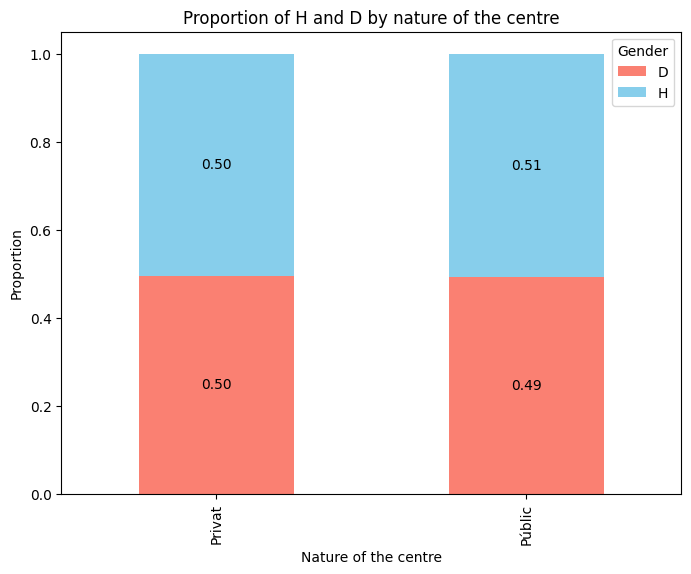

In [4]:
# Comparison of gender

import matplotlib.pyplot as plt

# Step 1: Calculate the counts of "H" and "D" for each category
counts = comp.groupby(['naturalesa', 'genere']).size().unstack(fill_value=0)

# Step 2: Calculate proportions by dividing by row sums
proportions = counts.div(counts.sum(axis=1), axis=0)

# Step 3: Plot a stacked bar chart
ax = proportions.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 6))

# Customize the plot
plt.title('Proportion of H and D by nature of the centre')
plt.xlabel('Nature of the centre')
plt.ylabel('Proportion')
plt.legend(title='Gender')

# Adding proportion labels on each bar
for i, (index, row) in enumerate(proportions.iterrows()):
    cumulative_height = 0  # Keeps track of where to place each label
    for j, proportion in enumerate(row):
        cumulative_height += proportion
        ax.text(i, cumulative_height - proportion / 2, f"{proportion:.2f}", ha='center', va='center', color='black')

plt.show()


### Spatial distribution

In [5]:
comp = comp[comp["any"] > 2017].copy() #This are the courses that will be compatible with investment dataset

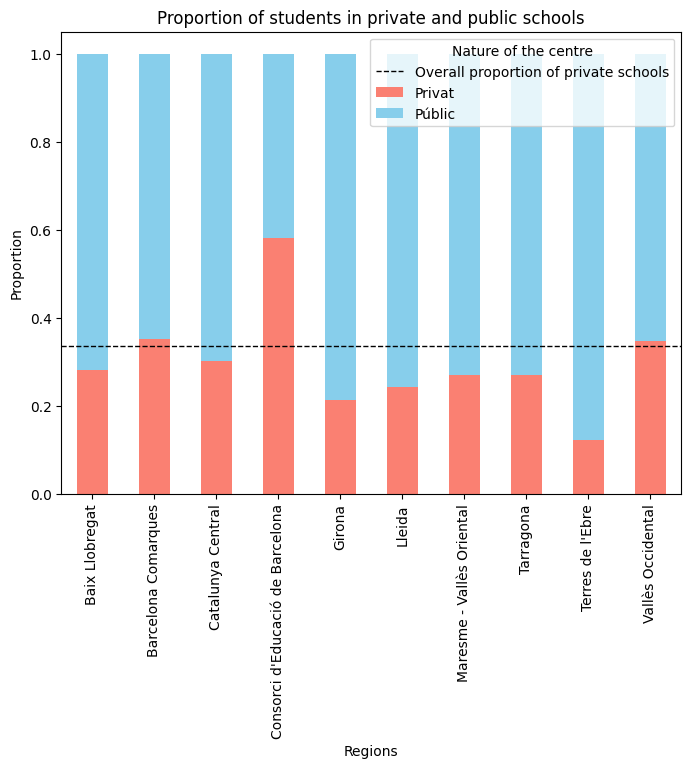

In [6]:

# Step 1: Calculate the counts of "Privat" and "Públic" for each category
counts = comp.groupby(['area_territorial', 'naturalesa']).size().unstack(fill_value=0)

# Step 2: Calculate proportions by dividing by row sums
proportions = counts.div(counts.sum(axis=1), axis=0)

# Step 3: Plot a stacked bar chart
ax = proportions.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 6))

# Calculate the overall counts of each 'naturalesa' category (e.g., private and public) across all areas
ccounts = comp['naturalesa'].value_counts()

# Calculate the overall proportion for "Privat" as a single value
hvalue = ccounts['Privat'] / (ccounts['Privat'] + ccounts['Públic'])

# Draw a single horizontal line for the overall "Privat" proportion
ax.axhline(y=hvalue, color='black', linestyle='--', linewidth=1, label='Overall proportion of private schools')

# Customize the plot
plt.title('Proportion of students in private and public schools')
plt.xlabel('Regions')
plt.ylabel('Proportion')
plt.legend(title='Nature of the centre')
plt.show()


#### Let's try with maps

In [7]:
mncps = gpd.read_file("../data/Municipis/mncps.shp")
mncps.rename(columns={'NOMREGIO': 'area_territorial', 'NOMMUNI': 'municipi'}, inplace=True)

regions = gpd.read_file("../data/Municipis/regions.shp")
regions.rename(columns={'NOMREGIO': 'area_territorial'}, inplace=True)

# Add region code
regions['code'] = range(len(regions))

# Add the coordinates to the dataframe
comp2 = comp.merge(regions, on='area_territorial')

C:\Users\judit\AppData\Local\Temp\ipykernel_22008\2114116363.py:7: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  proportions_gdf.plot(column='Privat',


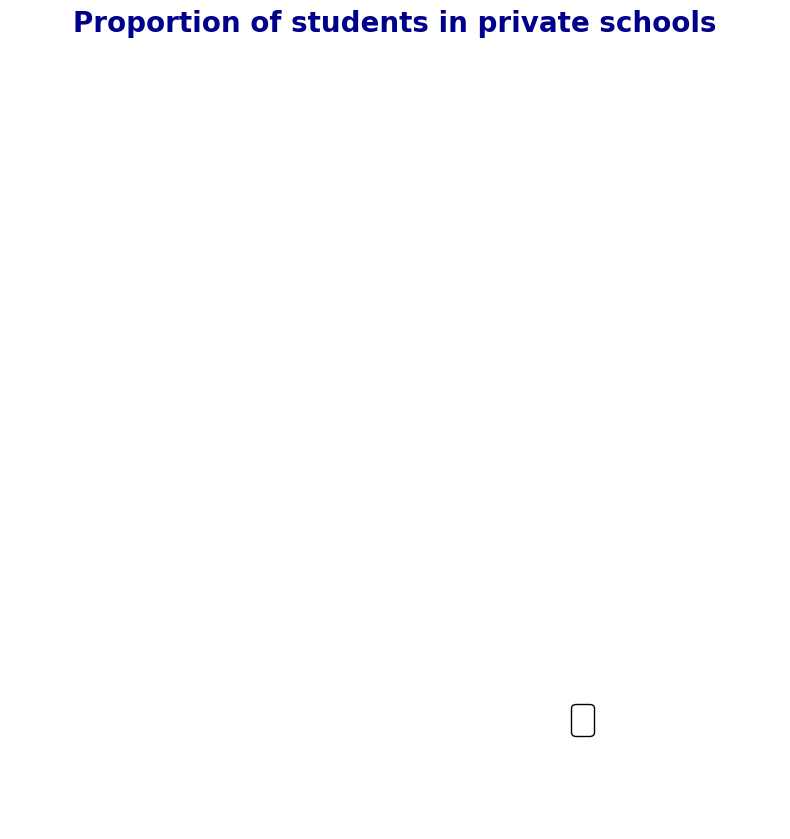

In [8]:
# Merge proportions and regions to form proportions_gdf
proportions2 = proportions.merge(regions, on='area_territorial')
proportions_gdf = gpd.GeoDataFrame(proportions2, geometry='geometry')

# Plot the map with regions colored by 'Privat'
fig, ax = plt.subplots(figsize=(10, 10))
proportions_gdf.plot(column='Privat', 
                     ax=ax, 
                     legend=True, 
                     cmap='coolwarm',  
                     missing_kwds={"color": "lightgrey", "label": "No data"},
                     legend_kwds={'shrink': 0.3})  

# Add region codes as text on the map
for idx, row in proportions_gdf.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, 
            row['code'], fontsize=8, ha='center', color='black')

# Create a string for the mapping of codes to region names
legend_text = "\n".join([f"{row['code']}: {row['area_territorial']}" for _, row in proportions_gdf.iterrows()])

# Create a box for the legend
legend_box = TextArea(legend_text, textprops=dict(fontsize=8, family='monospace'))
anchored_box = AnchoredOffsetbox(loc='lower center',  # Place at the bottom center
                                 child=legend_box,
                                 pad=0.5,
                                 frameon=True,  # Enable the box frame
                                 bbox_to_anchor=(0.7, 0.2),  # Offset below the plot
                                 bbox_transform=fig.transFigure,  # Use figure coordinates
                                 borderpad=0.5)
anchored_box.patch.set_boxstyle("round,pad=0.3")  # Rounded corners for the box
ax.add_artist(anchored_box)

# Customize the title
plt.title('Proportion of students in private schools', 
          fontsize=20,         
          fontweight='bold',   
          color='darkblue',    
          loc='center',        
          pad=20)              

plt.axis('off')  # Hide axes
plt.show()



## 2. Educational achievement

In [ ]:
# Calculate mean grades, not french
comp2[['pcat', 'pmat', 'pcast', 'pmed', 'pang']] = comp2[['pcat', 'pmat', 'pcast', 'pmed', 'pang']].apply(pd.to_numeric, errors='coerce')
comp2['mean_grade'] = comp2[['pcat', 'pmat', 'pcast', 'pmed', 'pang']].mean(axis=1)


Comparison of grades over regions

In [ ]:
def mean_map(year):
    year = (year)
    means_by_area = comp2[comp2['any'] == year].groupby('area_territorial', as_index=False)['mean_grade'].mean()
    means_by_area = means_by_area.merge(regions, on='area_territorial')
    means_by_area = gpd.GeoDataFrame(means_by_area, geometry='geometry')

    # Plot the map with regions colored by 'mean_grade'
    fig, ax = plt.subplots(figsize=(10, 10))
    means_by_area.plot(column='mean_grade', 
                        ax=ax, 
                        legend=True, 
                        cmap='coolwarm_r',  
                        missing_kwds={"color": "lightgrey", "label": "No data"},
                        legend_kwds={'shrink': 0.3})  

    # Add region codes as text on the map
    for idx, row in proportions_gdf.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, 
                row['code'], fontsize=8, ha='center', color='black')

    # Create a string for the mapping of codes to region names
    legend_text = "\n".join([f"{row['code']}: {row['area_territorial']}" for _, row in proportions_gdf.iterrows()])

    # Create a box for the legend
    legend_box = TextArea(legend_text, textprops=dict(fontsize=8, family='monospace'))
    anchored_box = AnchoredOffsetbox(loc='lower center',  # Place at the bottom center
                                    child=legend_box,
                                    pad=0.5,
                                    frameon=True,  # Enable the box frame
                                    bbox_to_anchor=(0.7, 0.2),  # Offset below the plot
                                    bbox_transform=fig.transFigure,  # Use figure coordinates
                                    borderpad=0.5)
    anchored_box.patch.set_boxstyle("round,pad=0.3")  # Rounded corners for the box
    ax.add_artist(anchored_box)

    # Customize the title
    plt.title('Mean grade in ' + str(year), 
            fontsize=20,         
            fontweight='bold',   
            color='darkblue',    
            loc='center',        
            pad=20)              

    plt.axis('off')  # Hide axes
    plt.show()



In [ ]:
mean_map(2021)

## 3. Achievement-expenditure correlation 
**Final results**

In [ ]:
# Data preparation

# Competences dataset
c_priv = comp2[comp2["naturalesa"] == "Privat"].copy()
c_priv.rename(columns={'any': 'curs_escolar'}, inplace=True)

priv_clean = c_priv.dropna(subset=['mean_grade'])

# Investment dataset
gprim2 = gprim.copy()
gprim2['curs_escolar'] = gprim['curs_escolar'].str.split('-').str[1] #so that they have the same format
# To convert
columns_to_convert = ['curs_escolar','brut', 'alumnes_pri', 'unitats_concertades_ede', 'unitats_concertades_einf', 'unitats_concertades_pri','unitats_concertades_eso','unitats_concertades_cfpm','unitats_concertades_batx','unitats_concertades_cfps']
# Aplicar la conversión a todas las columnas en la lista
gprim2[columns_to_convert] = gprim2[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [ ]:
# The aim of this code will be producing the dataframe df_corrs,
# which contains the mean grades and investment per pupil for each course and region

# Expenditure of each area and year
df_gastos = mncps.merge(gprim2,on = 'municipi').groupby(['curs_escolar', 'area_territorial'], as_index=False)['brut'].sum()
# Expenditure/students of each area and year
df_alumnos_total = mncps.merge(gprim2, on='municipi').groupby(['curs_escolar', 'area_territorial'], as_index=False).agg({'alumnes_pri': 'sum', 'unitats_concertades_ede': 'sum', 'unitats_concertades_einf': 'sum', 'unitats_concertades_pri' : 'sum','unitats_concertades_eso': 'sum','unitats_concertades_cfpm': 'sum','unitats_concertades_batx': 'sum','unitats_concertades_cfps': 'sum'})
df_alumnos_total['al_total'] = df_alumnos_total[['unitats_concertades_ede', 'unitats_concertades_einf', 'unitats_concertades_pri','unitats_concertades_eso','unitats_concertades_cfpm','unitats_concertades_batx','unitats_concertades_cfps']].sum(axis=1)

df_merged = df_gastos.merge(df_alumnos_total, on=['curs_escolar', 'area_territorial'])
df_merged['brut_per_alumne'] = df_merged['brut'] / df_merged['al_total']/1000 /df_merged['alumnes_pri']*df_merged['unitats_concertades_pri']

# Grades of each area and year
df_grades = priv_clean.groupby(['curs_escolar', 'area_territorial'], as_index = False)['mean_grade'].mean()

df_corrs = df_merged.merge(df_grades, on = ['curs_escolar', 'area_territorial'])

df_corrs2 = df_corrs.copy() # it will have the region codes for the map
df_corrs2['area_territorial'] = (df_corrs.index % 10).astype(str) + ', ' + df_corrs['area_territorial'] 

In [ ]:
# Correlation Coefficient
corr_coeff = np.corrcoef(df_corrs2['brut_per_alumne'], df_corrs2['mean_grade'])[0, 1]

# Sample size
n = len(df_corrs2)

# Standard error
SE_r = (1 - corr_coeff**2) / np.sqrt(n - 2)

print(f"Coeficiente de correlación (r): {corr_coeff}")
print(f"Error estándar: {SE_r}")

# Create the jointplot with scatter plot and marginal histograms
g = sns.jointplot(
    data=df_corrs2,
    x='brut_per_alumne',
    y='mean_grade',
    color='#313695',
    kind='scatter',  # Scatter plot in the center
    s=60,
    marginal_kws=dict(bins=20, fill=True, color='#4575b4')  # Histograms style
)

# Add the regression line to the scatter plot
sns.regplot(
    data=df_corrs,
    x='brut_per_alumne',
    y='mean_grade',
    scatter=False,
    color='#d7301f',
    ci=None,
    line_kws={'linestyle': '--', 'linewidth': 1},  # Dashed line and thinner width
    ax=g.ax_joint,  # Add the regression line to the main plot
    label=f'r = {corr_coeff:.2f} ± {SE_r:.2f}'  # Add the correlation info to the legend
)

# Customize axis labels
g.set_axis_labels('Investment (k€)', 'Mean Grade', fontsize=12)
# g.ax_joint.grid(True)

# Add the legend to the plot
plt.legend(loc='upper right', fontsize=12)

# Show the plot
plt.show()


In [ ]:
a_df = df_corrs2.groupby('area_territorial', as_index = False)['mean_grade'].mean()
b_df = df_corrs2.groupby('area_territorial', as_index = False)['brut_per_alumne'].mean()
im_df= a_df.merge(b_df, on ='area_territorial')

new_df = im_df.set_index('area_territorial')[[ 'mean_grade','brut_per_alumne']]
# Reorder the DataFrame by 'mean_grade' in increasing order
new_df = new_df.sort_values(by='mean_grade', ascending=False)

# normalize grades column
m_g = new_df.mean_grade.mean()
s_g = new_df.mean_grade.std()
new_df['mean_grade'] = (new_df['mean_grade'] - m_g)/s_g
# normalize investment column
m_i = new_df.brut_per_alumne.mean()
s_i = new_df.brut_per_alumne.std()
new_df['brut_per_alumne'] = (new_df['brut_per_alumne'] - m_i)/s_i



data = new_df.to_numpy()
# Create the imshow plot
plt.figure(figsize=(3, 6))
sns.heatmap(data, cmap='coolwarm', cbar_kws={'label': r'Typified value: $z = \frac{x-\bar{x}}{s}$'}, 
            xticklabels={'Mean grade','Investment'}, yticklabels=new_df.index, fmt='.2f')

plt.show()


In [ ]:
# The same as before
# Merge proportions and regions to form proportions_gdf
proportions2 = proportions.merge(regions, on='area_territorial')
proportions_gdf = gpd.GeoDataFrame(proportions2, geometry='geometry')

# Plot the map with regions colored by 'Privat'
fig, ax = plt.subplots(figsize=(10, 10))
proportions_gdf.plot(column='Privat', 
                     ax=ax, 
                     legend=True, 
                     cmap='coolwarm',  
                     missing_kwds={"color": "lightgrey", "label": "No data"},
                     legend_kwds={'shrink': 0.4})  

# Add region codes as text on the map
for idx, row in proportions_gdf.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, 
            row['code'], fontsize=10, ha='center', color='black') 

plt.axis('off')  # Hide axes
plt.show()

